# playing around with a network
https://grand.networkmedicine.org/cell/Lung_Cancer/
cellline HCC827

In [2]:
import pandas as pd
df = pd.DataFrame(pd.read_csv('../data/ACH-000012_A549_landmark.csv', index_col='Row'))

In [3]:
print(df.shape)
df

(962, 962)


,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
Row,,,,,,,,,,,,,,,,,,,,,
ABCB6,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ABCC5,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ABCF1,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ABCF3,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ABHD4,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF395,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ZNF451,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000
ZNF586,0.341329,-1.951228,0.232061,2.106346,0.725767,1.793261,3.264234,3.718504,-0.837045,0.742023,...,0.236303,-3.538113,0.240198,2.343712,-1.956795,1.798314,-0.791314,2.633620,-3.042847,-0.356005


In [4]:

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the adjacency matrix
G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

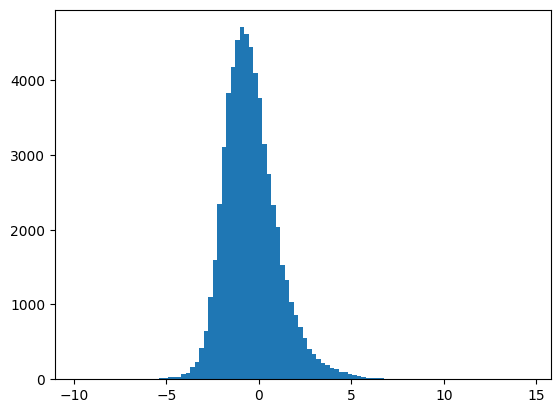

In [ ]:
# create histogram of the values in the adjacency matrix. ignore -1000 values
df.values.flatten()
plt.hist(df.values.flatten()[df.values.flatten() != -1000],bins=100)
plt.show()


In [21]:
# define a threshold and create a new dataframe with values below the threshold set to 0
threshold = 6
filtered_df = df.copy()

# count the original edges: number of values != -1000
# count the new edges: number of values > threshold
original_edges = (df.values != -1000).sum()
new_edges = (filtered_df.values > threshold).sum()
print(f'Original edges: {original_edges}, New edges: {new_edges}')

filtered_df[filtered_df < threshold] = 0

Original edges: 62530, New edges: 86


In [22]:
filtered_df

,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
Row,,,,,,,,,,,,,,,,,,,,,
ABCB6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCC5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABCF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABHD4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


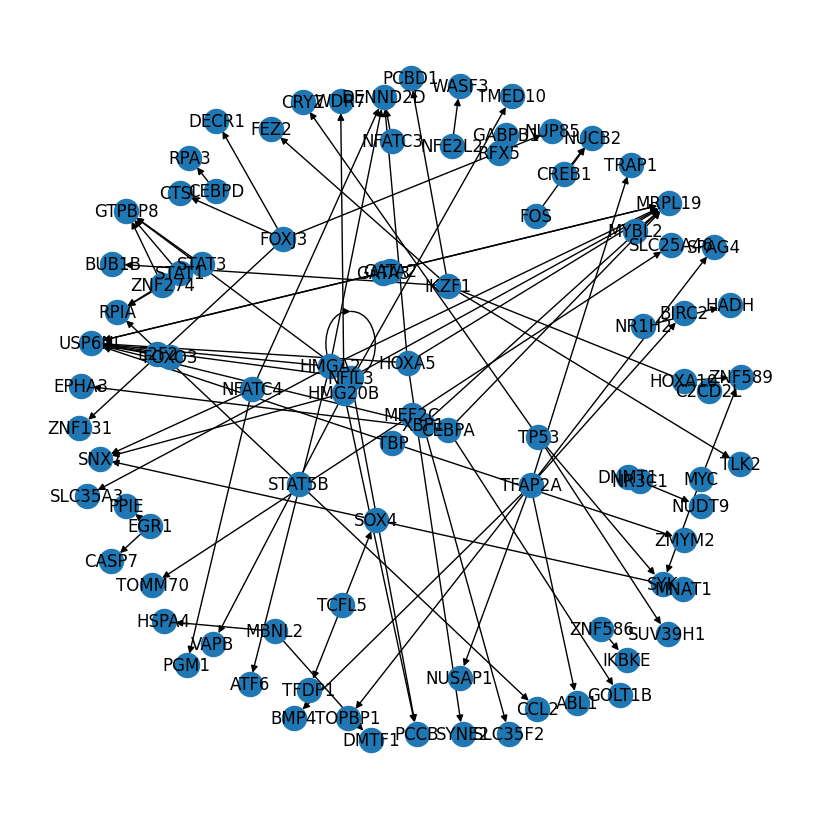

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the filtered adjacency matrix
G = nx.from_pandas_adjacency(filtered_df, create_using=nx.DiGraph)

# remove vertices with degree 0
G.remove_nodes_from(list(nx.isolates(G)))
plt.figure(figsize=(8, 8)) 
nx.draw(G, with_labels=True, node_size=300)  # Make the vertices smaller
plt.show()
